# Modeling Extremes - Numpyro Pt 3 - MCMC

In [1]:
import pandas as pd
import xarray as xr
from scipy.stats import genextreme
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
import seaborn as sns
import numpyro
from pyextremes import get_extremes
from pyextremes.plotting import plot_extremes
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import regionmask
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [37]:
# data_url = "/pool/datos/reanalisis/era5/daily/spain/025/t2max/*.nc"
data_url = "/pool/datos/reanalisis/era5/anomaly/spain/025/t2max/*.nc"
ds = xr.open_mfdataset(data_url)

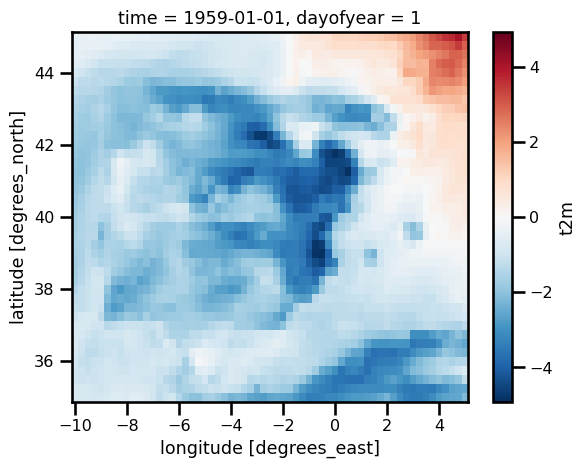

In [38]:
ds.t2m.isel(time=0).plot.pcolormesh()

## Masking

In [39]:
# get countries mask
countries = regionmask.defined_regions.natural_earth_v5_0_0.countries_110
# create mask variable
mask = countries.mask_3D(ds)
# select Spain mask
spain_mask = mask.isel(region=(mask.names=="Spain")).squeeze()

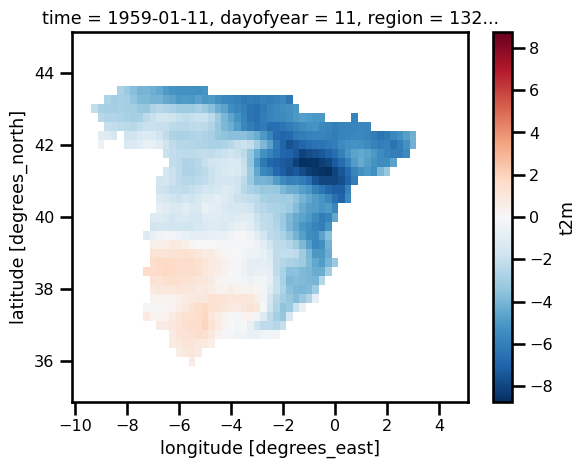

In [40]:
ds.where(spain_mask.squeeze()).isel(time=10).t2m.plot()

In [41]:
# get land-sea-mask mask
land_110 = regionmask.defined_regions.natural_earth_v5_0_0.land_110
# create land mask variable
land_mask = land_110.mask_3D(ds)

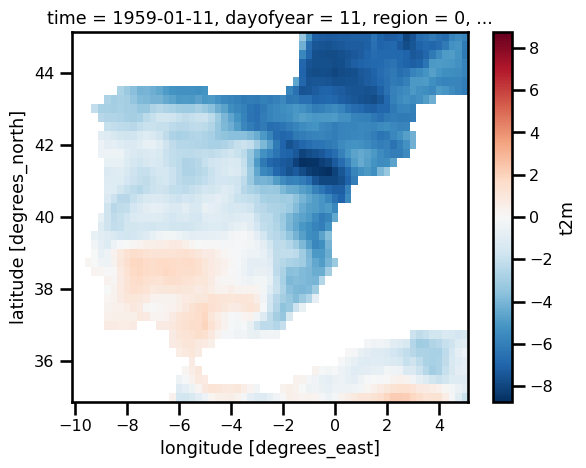

In [42]:
ds.where(land_mask.squeeze()).isel(time=10).t2m.plot()

## Clean Data

* Take Weighted Mean
* Convert Kelvin to Celsius
* Convert to DataFrame & Series
* Drop NANS
* Sort according to time
* Small Correction to Date

In [43]:
# # take weighted spatial mean
# import numpy as np
# weights = spain_mask.squeeze() * np.cos(np.deg2rad(ds.latitude))
# ds = xr.open_mfdataset(data_url)
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"]) - 272.15

### Region Selection

We are going to select Spain but also perhaps Madrid.

In [45]:
# # take weighted spatial mean
# weights = spain_mask * np.cos(np.deg2rad(ds.latitude))
# data = ds.weighted(weights).mean(dim=["latitude", "longitude"])

# select MADRID region
data = ds.sel(longitude=-3.703790, latitude=40.416775, method="nearest")

In [46]:

# # convert Kelvin to Celcius
# data -= 272.15
# convert to dataframe
data = data.t2m.to_dataframe()
# create time series
data = pd.Series(data["t2m"])
# remove nans
data = data.dropna()
# sort ascending
data = data.sort_index(ascending=True)
# # start time
t0 = data.index[0]
# # rescale time
data = data - (data.index.array - pd.to_datetime(t0.year)) / pd.to_timedelta("365.2425D") * 2.87e-3
data.describe()

count    23011.000000
mean        -0.382247
std          3.740105
min        -16.210242
25%         -2.915719
50%         -0.283981
75%          2.215052
max         12.947272
Name: t2m, dtype: float64

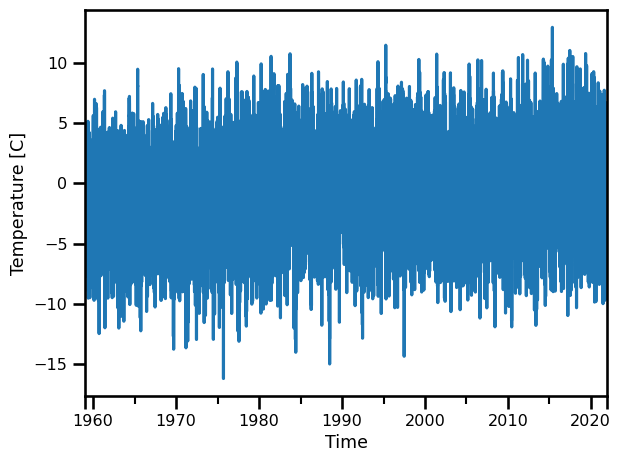

In [47]:
fig, ax = plt.subplots()

data.plot(ax=ax)

ax.set(
    xlabel="Time",
    ylabel="Temperature [C]"
)
plt.tight_layout()
plt.show()

## Extremes

In [59]:
extremes_method = "BM"
block_size = f"{3*30}D" # "365.2425D" # 
extremes_type = "high"
extremes = get_extremes(
    data, 
    method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

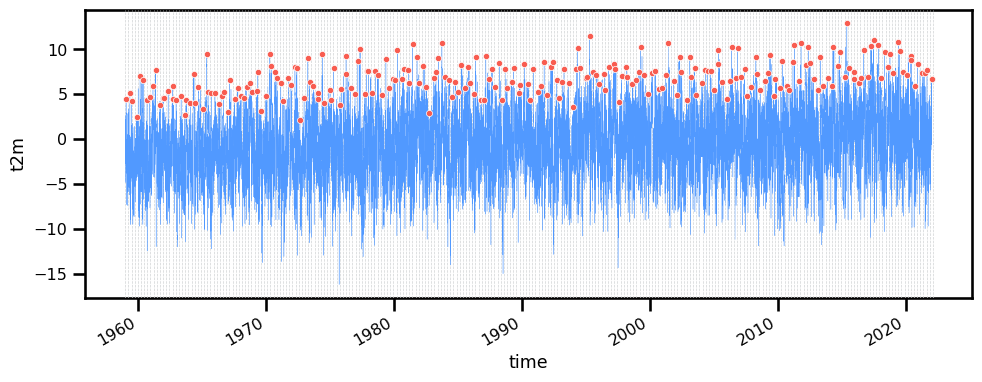

In [60]:
fig, ax = plt.subplots(figsize=(10,4))

plot_extremes(
    ax=ax,
    ts=data,
    extremes=extremes,
    extremes_method=extremes_method,
    extremes_type=extremes_type, 
    block_size=block_size,
)

plt.tight_layout()
plt.show()

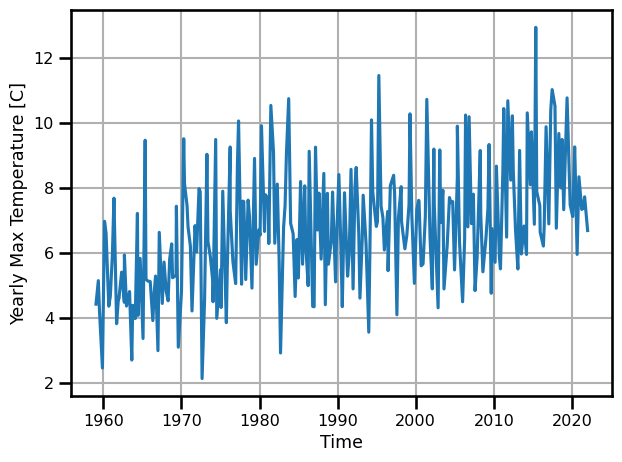

In [61]:
fig, ax = plt.subplots()

ax.plot(extremes)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.tight_layout()
plt.show()

In [62]:
t0 = pd.to_datetime("1990")
extremes_before = extremes.loc[:t0]
extremes_after = extremes.loc[t0:]

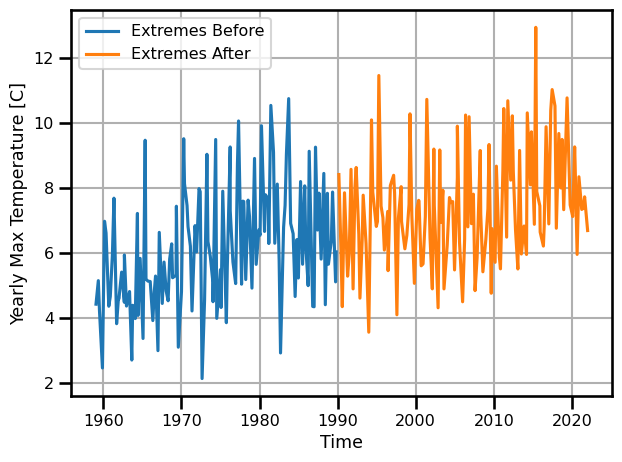

In [63]:
fig, ax = plt.subplots()

ax.plot(extremes_before, label="Extremes Before")
ax.plot(extremes_after, label="Extremes After")
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [64]:
def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.sample("loc", dist.Normal(0.0, 5.0))
    scale = numpyro.sample("scale", dist.LogNormal(0.0, 10.0))
    concentration = numpyro.sample("concentration", dist.LogNormal(loc=0.0, scale=2.0))
    
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

### Sampling: MCMC

In [65]:
rng_key = jrandom.PRNGKey(123)

In [66]:
models_saved = {}

In [67]:
def run_model(model, y):

    # initialize kernel
    nuts_kernel = NUTS(model)
    
    # initial mcmc scheme
    num_warmup = 1_000
    num_samples = 2_000
    mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
    
    mcmc.run(rng_key=rng_key, y=y)
    
    return mcmc

In [68]:
models_saved["before"] = run_model(model, extremes_before.values)
models_saved["after"] = run_model(model, extremes_after.values)

sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 367.58it/s, 3 steps of size 6.61e-01. acc. prob=0.89]


## Model Diagnostics

In [69]:
models_saved["before"].print_summary()
models_saved["after"].print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  concentration      0.03      0.02      0.02      0.00      0.06   1561.54      1.00
            loc      5.23      0.16      5.23      4.96      5.48   1179.36      1.00
          scale      1.65      0.11      1.65      1.48      1.83   1221.27      1.00

Number of divergences: 1

                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  concentration      0.02      0.02      0.02      0.00      0.05   1685.52      1.00
            loc      6.60      0.15      6.60      6.36      6.86   1238.76      1.00
          scale      1.60      0.11      1.59      1.42      1.77   1307.94      1.00

Number of divergences: 0


In [70]:
# import arviz as az

# mcmc_arxiv = az.from_numpyro(mcmc)
# az.plot_trace(mcmc_arxiv, compact=True, figsize=(10, 5));
# plt.tight_layout()

In [71]:
# az.plot_ppc(mcmc_arxiv, figsize=(10, 5));
# plt.tight_layout()

In [72]:
# mcmc_arxiv.observed_data

In [73]:
list(ds.t2m.groupby("time.season"))[0]

('DJF',
 <xarray.DataArray 't2m' (time: 5686, latitude: 41, longitude: 61)>
 dask.array<getitem, shape=(5686, 41, 61), dtype=float64, chunksize=(91, 41, 61), chunktype=numpy.ndarray>
 Coordinates:
   * time       (time) datetime64[ns] 1959-01-01 1959-01-02 ... 2021-12-31
     dayofyear  (time) int32 dask.array<chunksize=(90,), meta=np.ndarray>
   * longitude  (longitude) float32 -10.0 -9.75 -9.5 -9.25 ... 4.25 4.5 4.75 5.0
   * latitude   (latitude) float32 45.0 44.75 44.5 44.25 ... 35.5 35.25 35.0)

## Posterior Samples

In [74]:
def plot_gevd_parameter_pdf(posterior_samples):

    fig, ax = plt.subplots(ncols=3, figsize=(14,4))
    
    
    ax[0].hist(posterior_samples["concentration"], 
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=False, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
               
    )
    ax[1].hist(posterior_samples["loc"], 
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=False, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
    )
    ax[2].hist(posterior_samples["scale"],
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=False, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
    )


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

def plot_gevd_parameter_cdf(posterior_samples, fig=None, ax=None):

    fig, ax = plt.subplots(ncols=3, figsize=(14,4))
    
    
    ax[0].hist(posterior_samples["concentration"], 
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=True, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Shape ($\xi$)",
               
    )
    ax[1].hist(posterior_samples["loc"], 
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=True, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Location ($\mu$)"
    )
    ax[2].hist(posterior_samples["scale"],
               bins=25, rwidth=2, alpha=0.9, 
               cumulative=True, density=True, 
               color="tab:blue", linewidth=3, histtype="step", label=r"Scale ($\sigma$)"
    )


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()

    plt.tight_layout()
    plt.show()

    return fig, ax

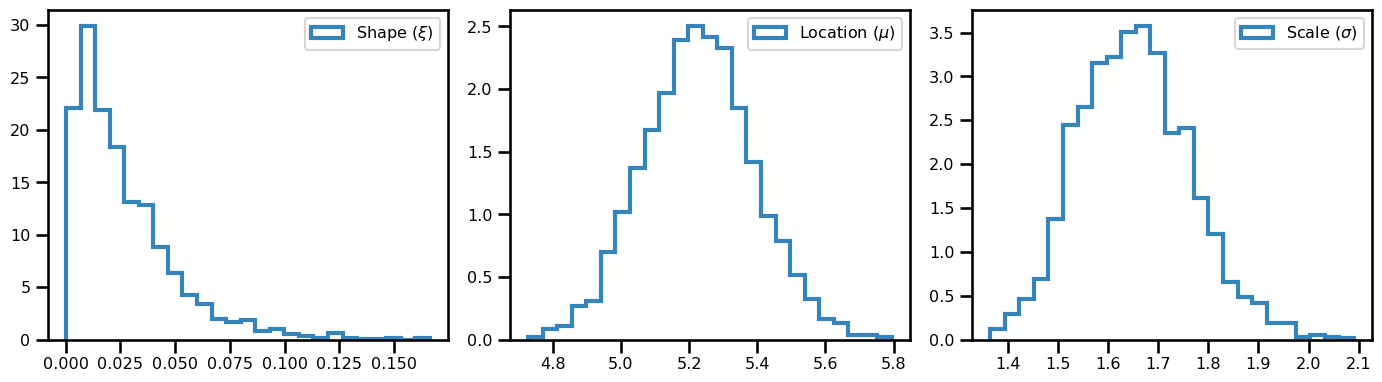

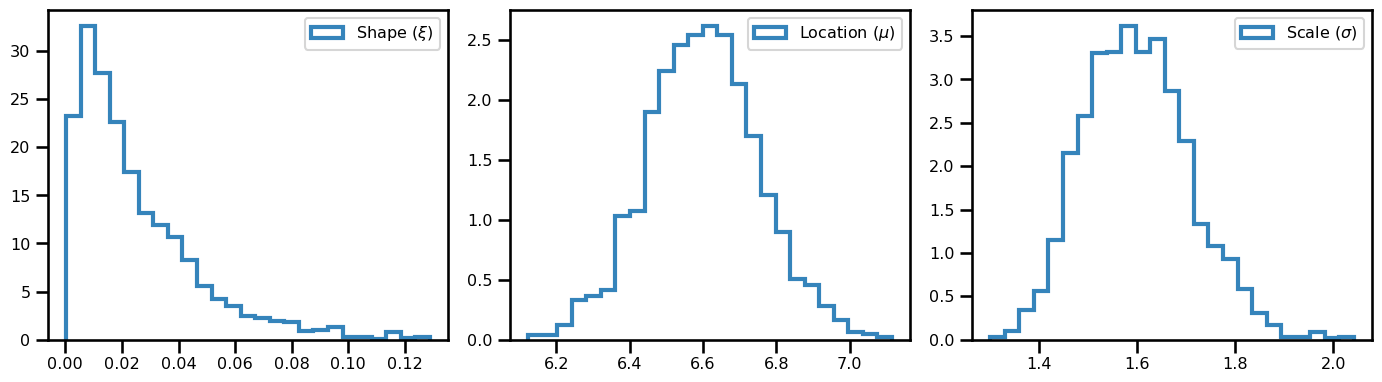

In [75]:
plot_gevd_parameter_pdf(models_saved["before"].get_samples());
plot_gevd_parameter_pdf(models_saved["after"].get_samples());

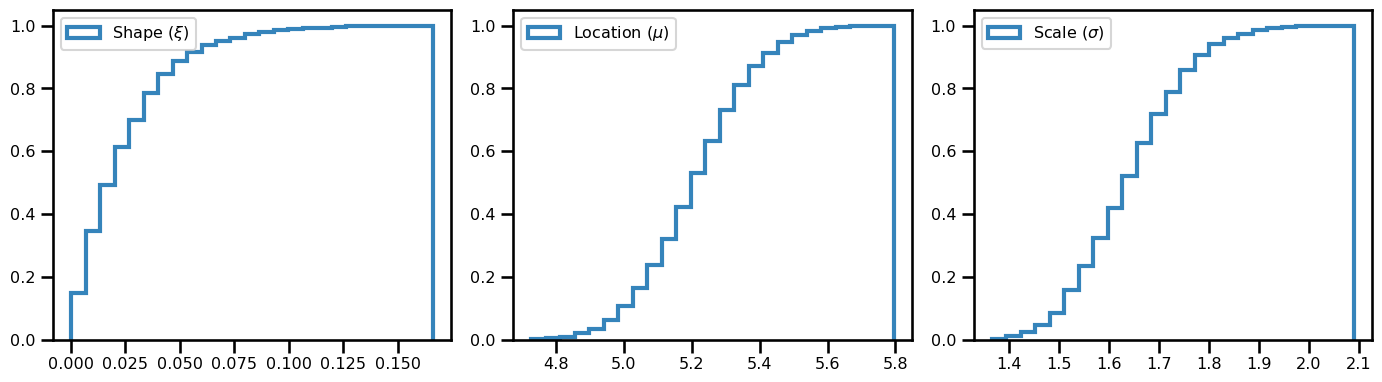

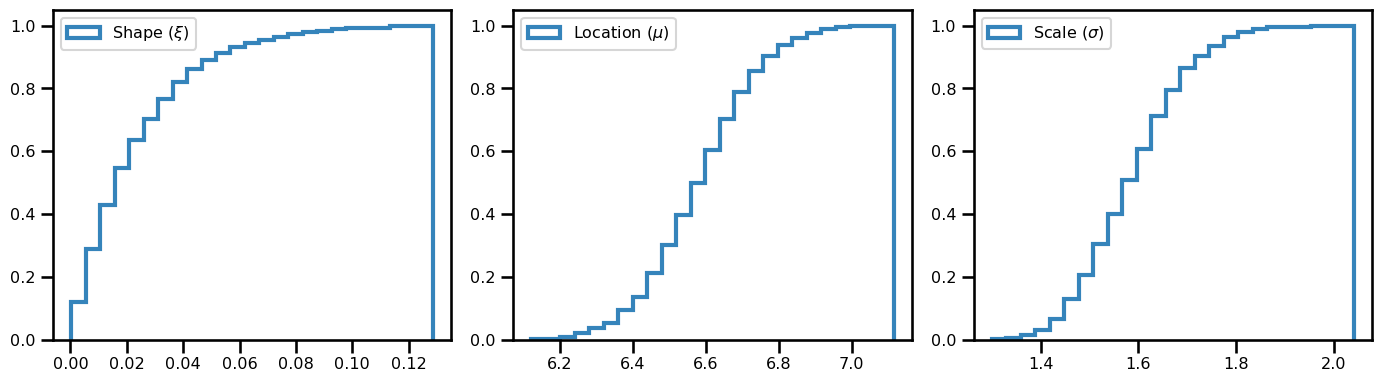

In [76]:
plot_gevd_parameter_cdf(models_saved["before"].get_samples());
plot_gevd_parameter_cdf(models_saved["after"].get_samples());

## Return Period

In [77]:
import numpy as np
from scipy.stats import genextreme
from jax.debug import print as jprint

return_periods = np.logspace(-0.999, 2, 100)

In [78]:


def calculate_return_levels(params):
    model = tfd.GeneralizedExtremeValue(
        loc=params["loc"], 
        scale=params["scale"], 
        concentration=params["concentration"]
    )
    return model.quantile(1-1/return_periods)

In [79]:
return_levels_before = jax.vmap(calculate_return_levels)(models_saved["before"].get_samples())
return_levels_after = jax.vmap(calculate_return_levels)(models_saved["after"].get_samples())

In [80]:
def plot_return_period(return_periods, return_levels_before, return_levels_after):

    

    fig, ax = plt.subplots(figsize=(6,6))

    ciu, mu, cil = np.quantile(return_levels_before, q=[0.025, 0.5, 0.975], axis=0)
    ax.plot(
        return_periods, mu, 
        linestyle="--", linewidth=3, color="tab:blue",
        label="Historical Climate",
    )
    ax.fill_between(
        return_periods, 
        cil, ciu,
        alpha=0.3,
        color="tab:blue",
        label="95% Confidence Interval",
    )
    

    ciu, mu, cil = np.quantile(return_levels_after, q=[0.025, 0.5, 0.975], axis=0)
    
    ax.plot(
        return_periods, mu, 
        linestyle="--", linewidth=3, color="tab:red",
        label="Current Climate",
    )
    ax.fill_between(
        return_periods, 
        cil, ciu,
        alpha=0.3,
        color="tab:red",
        label="95% Confidence Interval",
    )
    

    
    ax.set(
        xlabel="Return Period [years]",
        ylabel="Return Levels (Anomalies) [°C]",
        xscale="log",
        xlim=[1.0, 110.0],
        xticks=[1.0, 10.0, 100.0]
        # ylim=[1, 10]
    )
    # format log scale labels
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax.xaxis.set_major_formatter(formatter)s

    def one_over(x):
        """Vectorized 1/x, treating x==0 manually"""
        x = np.array(x, float)
        near_zero = np.isclose(x, 0)
        x[near_zero] = np.inf
        x[~near_zero] = 1 / x[~near_zero]
        return x
    
    
    # the function "1/x" is its own inverse
    inverse = one_over

    secax = ax.secondary_xaxis("top", functions=(one_over, inverse))
    secax.set_xlabel("Probability")
    secax.set_xticks([0.1, 0.01])

    # formatter = ScalarFormatter()
    # formatter.set_scientific(False)
    secax.xaxis.set_major_formatter(formatter)
    
    plt.grid(which="both", visible=True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return None

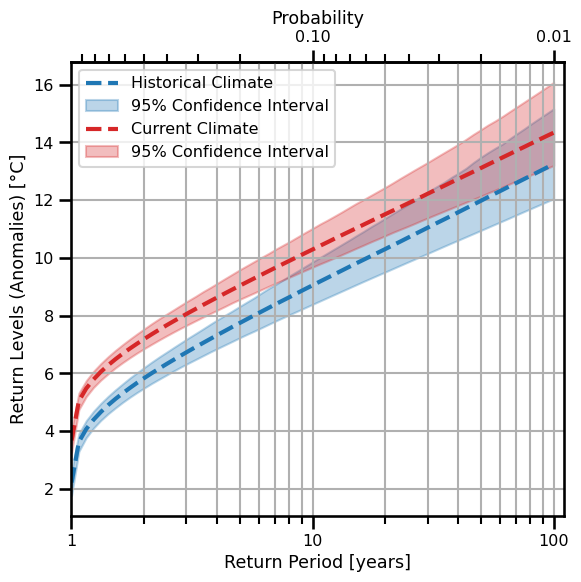

In [81]:
plot_return_period(return_periods, return_levels_before, return_levels_after)

In [36]:
1/return_periods

array([9.97700064, 9.3048006 , 8.67789001, 8.0932175 , 7.54793728,
       7.03939529, 6.5651163 , 6.12279184, 5.71026898, 5.32553982,
       4.96673178, 4.63209841, 4.32001096, 4.02895038, 3.75750001,
       3.50433859, 3.26823391, 3.04803677, 2.84267541, 2.65115026,
       2.47252911, 2.30594256, 2.15057977, 2.00568454, 1.87055162,
       1.74452327, 1.62698608, 1.51736796, 1.41513535, 1.31979066,
       1.23086981, 1.14794001, 1.07059759, 0.99846612, 0.9311945 ,
       0.86845531, 0.80994317, 0.75537328, 0.70448003, 0.65701572,
       0.61274931, 0.57146535, 0.53296289, 0.49705453, 0.4635655 ,
       0.4323328 , 0.40320439, 0.37603851, 0.35070293, 0.32707433,
       0.30503771, 0.28448581, 0.26531859, 0.24744276, 0.23077131,
       0.2152231 , 0.20072245, 0.18719879, 0.17458628, 0.16282353,
       0.1518533 , 0.14162219, 0.1320804 , 0.12318149, 0.11488214,
       0.10714196, 0.09992328, 0.09319095, 0.08691221, 0.08105651,
       0.07559533, 0.07050209, 0.06575202, 0.06132198, 0.05719